# Éléments finis pour l'équation de Poisson 2D

Dans ce TP, on s'intéresse à la résolution approchée du problème aux limites suivant, avec conditions aux limites de Dirichlet homogène :

$$
(P)\left\{\begin{aligned}
&-\Delta u=f,\ \textrm{dans }\Omega,\\
&u=0, \textrm{dans }\partial\Omega
\end{aligned}
\right.
$$
où $f:\overline{\Omega}\longrightarrow\mathbb{R}$ est une fonction de classe $\mathcal{C}^2$ donnée et où $\Omega$ est un ouvert de $\mathbb{R}^2$ donné. 

----------------------------------------------------------

**Question 1.** Écrire la formulation variationnelle du problème $(P)$ sous la forme 
\begin{equation*}
(Pv)\ \ \ 
\begin{cases}
u\in V  \,\textrm{tel que}\\
a(v,u)=L(v),\ \,\forall\ v\in V ,
\end{cases}
\end{equation*}
où $V=H^1_0(\Omega)$, $a$ est une forme bilinéaire dans $V$  et $L$ une forme linéaire de $V,$ que l'on explicitera. Justifier que $(Pv)$ admet une et une seule solution.

-------------------------------------------------------------------

On considère une triangulation $T_h$ du domaine $\Omega$ et $V_h$ l'approximation de $H^1(\Omega)$ par des éléments finis $P^1$ associés à la triangulation $T_h$ :

$$
V_h=\{\Phi\in C^0(\overline{\Omega})\,|\,\Phi_{|T}\in\mathbb{P}^1,\ \textrm{pour tout } T\in T_h\}.
$$

On note $\{T_N\}_{N=1,\dots,Ntri}\ \ \ $ les triangles de $T_h,$ $\{S_I\}_{I=1,\dots,NSom}\  \ \ $ les sommets des triangles de la triangulation et $\{\Phi_I\}_{I=1,\dots,NSom}\ \ \ $ les fonctions de la base de $V_h$ définies par $\Phi_I(S_J)=\delta_{IJ},\ I,J=1,\dots,NSom.$ 

L'espace $V_h^0$ que l'on considèrera pour approcher $H^1_0$ sera constitué des éléments $\Phi_I$ de la base de $V_h$ tels que $I$ n'est pas un sommet appartenant au bord $\partial \Omega$ de $\Omega$. Pour cela, il faut  référencer les sommets $I$ qui sont dans le bord.

** Maillage de $\Omega.$ **

Dans un premier temps on considère $\Omega$ le carré $[0,2]\times[0,2].$ 

Pour se répérer dans le maillage du domaine $\Omega$, les triangles et les sommets des triangles sont numérotés respectivement de $1$ à $NTri$ et de 1 à $NSom$.

La triangulation $T_h$ de $\Omega$ est alors représentée par deux matrices. La première, que l'on appellera dans le programme python $TabTri,$ contient la liste des triangles. Il s'agit d'une matrice de taille $NTri\times3$ que, dans chaque ligne $N$, contient les 3 indices $I$ des sommets du triangle $T_N.$ La deuxième, que l'on appellera $TabSom,$ contient les coordonnées de chaque sommet de la triangulation. C'est une matrice de taille $NSom\times2$ que, dans chaque ligne $I$ contient les coordonnées du sommet $S_I.$ 
Le code suivant crée le maillage et ces matrices.

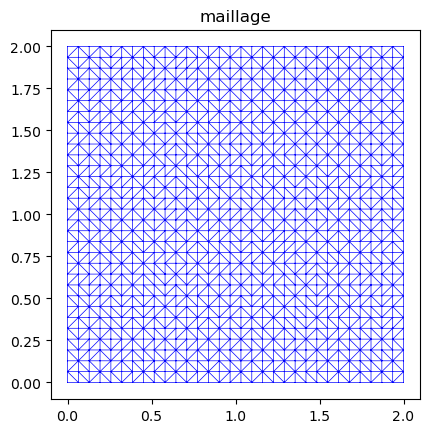

In [1]:
%matplotlib inline

import scipy 
from scipy import linalg
from scipy import sparse
from scipy.sparse import linalg
from scipy.sparse import bsr_matrix
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri
import math
import numpy.random as rd


Nx=30
Ny=30

x_m=0.
x_M=2.
y_m=0.
y_M=2.

x=np.linspace(x_m,x_M,Nx+2)
y=np.linspace(y_m,y_M,Ny+2)

X,Y=np.meshgrid(x,y)

X=X.flatten()
Y=Y.flatten()

triang = tri.Triangulation(X, Y)

NTri=np.shape(triang.triangles)[0]
NSom=np.shape(triang.x)[0]

#Tableau avec coordonnes des noeuds
TabSom=np.zeros([NSom,2])
TabSom[:,0]=triang.x
TabSom[:,1]=triang.y

# Tableau avec noeuds des triangles
TabTri=triang.triangles

# Représentation du maillage
plt.figure(1)
plt.gca().set_aspect('equal')
plt.triplot(X,Y,triang.triangles, 'b-', lw=0.5)
plt.title('maillage')

plt.show()



**Question 1.** Compléter le code précédent, qui génère le maillage et les tableaux $TabTri,$ contenant la liste des triangles, et $TabSom,$ contenant les coordonnées de chaque sommet de la triangulation, pour créer un tableau $RefSom$, de taille $NSom\times 1$, que dans chaque ligne $I$ prendra la valeur $1$ si le sommet $I$ appartient à $\partial\Omega$, et $0$ sinon.

In [2]:
# Tableau avec référence des noeuds
RefSom=np.zeros([NSom,1])
for i in range(NSom):
    S=TabSom[i]
    if ((S[0] == 0) or (S[0]==2) or (S[1] == 0) or (S[1]==2)):    #on est sur le bord
        RefSom[i] = 1

On note 

$$
S_0=\big\{I\in \{1,\dots,NSom\}\ \,:\ \,S_I\notin\partial\Omega\big\}
$$

l'ensemble contenant les sommets de la triangulation appartenant à l'intérieur de $\Omega$. 

On définit alors

$$
V_h^0=Vect\big(\{\Phi_I\ \,:\ \,I\in S_0\}\big).
$$

Le problème discret que l'on va résoudre consiste alors à chercher $u_h\in V_h^0$ tel que 
$$
(P_h)\ \ \ \ \ \ \ \ \ a(\Phi_I,u_h)=L(\Phi_I),\ \,\forall\ I\in S_0. 
$$

---------------------------------------------------------


**Question 2.** Soit $u_h=\displaystyle{\sum_{I\in S_0}u_I\Phi_I}.$ Supposons que 

$$
S_0=\{I_{i1},\dots,I_{iS},\ \ \textrm{avec }\ i1<\dots<iS\}.
$$
Montrer que $u_h$ est solution de $(P_h)$ si et seulement si le vecteur $U=(u_{i1},\dots,u_{iS})^T$ est solution d'un système linéaire 
$$
AU=F,
$$
où l'on précisera la matrice $A$ et le second membre $F$. Montrer que $A$ est une matrice inversible et que donc $(P_h)$ admet une unique solution.

-----------------------------------------------------------


Le système matricielle $AU=F$ s'agit d'un système analogue à celui de la discrétisation du problème de Neumann, mais dont la matrice  est de taille égale au cardinal de $S_0$, au lieu de taille $NSom$. 

En pratique on ne construit pas cette matrice de taille plus petite. On va construire une matrice de taille $NSom$, contenant les termes $A_{IJ}=a(\Phi_J,\Phi_I)$ correspondant aux sommets du bord $\partial \Omega$, mais on va la modifier dans les lignes et colonnes correspondant à ces noeuds. On fait le même pour le vecteur $F$. On obtient un système matricielle de taille $NSom$ et on le modifie de sort à ce que, si $I\notin S_0$, l'équation $I$ de ce système soit la condition de Dirichlet 

$$
U_I=0.
$$

Pour ce faire, on modifie la valeur de $F_I$ en la mettant à 0, et on modifie les ligne et colonne $I$ de $A$ en mettant tous ses coefficients à $0$, à l'exception du coefficient $A_{II}$ que l'on met par exemple égal à $1$. 

Cette méthode est connue sous le nom de *pseudo-élimination*.


** Les matrices élémentaires **

Pour construire la matrice $A$ il est utile de définir des matrices élémentaires qui permettent, localement sur un triangle $T_N$ de noeuds $S_{I_1},\ S_{I_2}$ et $S_{I_3},$ de calculer 
$$
\int_{T_N}\nabla\Phi_{I_i} \cdot \nabla\Phi_{I_j}
$$
pour $i,\ j=1,2,3.$ Cette intégrale va contribuer à l'élément $A_{I_i,I_j}$ de la matrice globale.

----------------------------------------------------------

**Question 3.** Construire une fonction $K_{elem}(\mathcal{S1},\mathcal{S2},\mathcal{S3})$ calculant une matrice $3\times 3$ contenant dans l'élément $i,j$ la valeur de l'intégrale ci-dessus sur un triangle $T$ de sommets $\mathcal{S1}=(x_1,y_1),\ \mathcal{S2}=(x_2,y_2)$ et $\mathcal{S3}=(x_3,y_3).$  
Pour calculer cette matrice, on peut utiliser les formules ci-dessous.

-------------------------------------------------------

Les fonctions de base associées à chaque sommet $S_i$ de $T,\ i=1,\ 2,\ 3,$ sont localement données par
$$
\lambda_1(x,y)=\frac{1}{D}(y_{23}(x-x_3)-x_{23}(y-y_3)),\ \ \ \lambda_2(x,y)=\frac{1}{D}(y_{31}(x-x_1)-x_{31}(y-y_1)),\ \ \ \lambda_3(x,y)=\frac{1}{D}(y_{12}(x-x_2)-x_{12}(y-y_2)),
$$
où $x_{ij}=x_i-x_j,\ y_{ij}=y_i-y_j$ et $D=x_{23}y_{31}-x_{31}y_{23}.$ $|D|$ est égal à deux fois la surface du triangle.



** Assemblage de la matrice $A.$**

Dans cette partie on met en oeuvre un algorithme pour construire la matrice $A.$ Pour ce faire on remarque que, par exemple, 
$$
A_{I,J}=\sum_{N=1}^{NTri}\int_{T_N}\nabla \Phi_I\cdot\nabla\Phi_J=\sum_{N : S_I,S_J\in T_N}\int_{T_N}\nabla \Phi_I\cdot\nabla\Phi_J.
$$

L'algoritme de construction de la matrice consiste alors à faire la boucle suivante :

    Pour N= 1...NTri
         Détérmination des sommets S_I1, S_I2 et S_I3 du triangle T_N
         Calcul d'une matrice élémentaire associée au triangle T_N
             Pour i=1..3
                Pour j=1...3 
                    A(Ii,Ij)=A(Ii,Ij)+A_elem(i,j)

-----------------------------------------------

**Question 4.** Compléter dans le programme l'assemblage de la matrice A.

----------------------------------------------------


**Calcul du second membre $F.$**

On peut calculer exactement les composantes $F_I$ du vecteur $F$ ou approcher ses valeurs en utilisant par exemple des formules de quadrature.

Ici on fait le choix de remplacer $f$ par son interpolé $P^1$ aux points du maillage, *i.e.* on approche $f$ par la fonction $\displaystyle{\sum_{I=1}^{NSom}f(S_I)\Phi_I}.$ 

-----------------------------------------------------------------

**Question 5.** En approchant $f$ par son interpolé, donner une approximation du second membre $F$ faisant intervenir la matrice de masse.  

----------------------------------------------------------------

On admet que cette approximation ne change pas l'approximation par éléments finis du problème. 

---------------------------------------------------------------

**Question 6.** Mettre en oeuvre la procédure de *pseudo-élimination* et construire un programme qui donne la solution approchée du problème $(P_h)$. 

--------------------------------------------------------------------

** Remarque : une autre méthode pour le calcul des matrices élémentaires **

On peut essayer de calculer les matrices élémentaires référentes à un triangle $T_l$ en faisant un changement de variables qui ramène les intégrales à calculer à des intégrales dans un triangle $T$ de référence, qui est le triangle de sommets $(0,0),\ (1,0)$ et $(0,1)$. Pour cela construire la transformation affine 
$
\varphi:\mathbb{R}^2\longrightarrow \mathbb{R}^2
$
telle que $\varphi(T)=T_l$. On remarque que $\varphi$ est de la forme 
$$
\varphi
\Big(
\begin{array}{c}
x\\y
\end{array}
\Big)=AA\Big(
\begin{array}{c}
x\\y
\end{array}
\Big)+
\Big(
\begin{array}{c}
b_1\\b_2
\end{array}
\Big),
$$
avec $AA$ matrice $2\times2$ et $b_1,\ b_2\in\mathbb{R}$ à déterminer.

Q.3:

In [3]:
def K_elem(S1,S2,S3):
    #pour faciliter la lecture
    x1,y1 = S1[0],S1[1]
    x2,y2 = S2[0], S2[1]
    x3,y3 = S3[0], S3[1]
    
    #aire
    D = abs((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1))
    
    X=[[0,x1-x2,x1-x3] , [x2-x1,0,x2-x3], [x3-x1,x3-x2,0]]
    Y=[[0,y1-y2,y1-y3] , [y2-y1,0,y2-y3], [y3-y1,y3-y2,0]]
    
    Kel = np.zeros((3,3))
    
    Kel[0][0]=1/(2*D)*(Y[1][2]**2+X[1][2]**2)
    Kel[0][1] =1/(2*D)*(Y[1][2]*Y[2][0]+X[1][2]*X[2][0])
    Kel[0][2]=1/(2*D)*(Y[1][2]*Y[0][1]+X[1][2]*X[0][1])
    
    Kel[1][0]=Kel[0][1]
    Kel[1][1]=1/(2*D)*(Y[2][0]**2+X[2][0]**2)
    Kel[1][2]=1/(2*D)*(Y[2][0]*Y[0][1]+X[2][0]*X[0][1])
    
    Kel[2][0]=Kel[0][2]
    Kel[2][1]=Kel[1][2]
    Kel[2][2]=1/(2*D)*(Y[0][1]**2+X[0][1]**2)
    
    return Kel

In [4]:
def M_elem(S1,S2,S3):
    x1,y1 = S1[0],S1[1]
    x2,y2 = S2[0], S2[1]
    x3,y3 = S3[0], S3[1]
    #aire
    D = ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1))
    Mel = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            if (i==j):
                Mel[i][j] = 1/6*abs(D)
    
            else:
                Mel[i][j]=1/12*abs(D)
                
    return Mel

Ces matrices correspondent aux matrices que j'obtiens avec mon programme MatLab, qui est correct.

Q4:

In [5]:

KK=np.zeros((NSom,NSom))

MM=np.zeros((NSom,NSom))
NTri = len(TabTri)

for i in range(NTri):
    k,l,m=TabTri[i][0],TabTri[i][1],TabTri[i][2]
    S1,S2,S3 = TabSom[k], TabSom[l],TabSom[m]
    
    Kel=K_elem(S1,S2,S3)
    Mel=M_elem(S1,S2,S3)
    
    #on effectue l'assemblage de M
    MM[k][k] += Mel[0][0]
    MM[l][l] += Mel[1][1]
    MM[m][m] += Mel[2][2]
  
    MM[k][l]+= Mel[0][1]
    MM[k][m]+=Mel[0][2]
  
    MM[l][m]+=Mel[1][2]
    MM[l][k] += Mel[1][0]
  
    MM[m][k] += Mel[2][0]
    MM[m][l]+= Mel[2][1]
    
    #Puis, on procède à l'assemblage de K

    KK[k][k] += Kel[0][0]
    KK[l][l] += Kel[1][1]
    KK[m][m] += Kel[2][2]
  
    KK[k][l]+= Kel[0][1]
    KK[k][m]+=Kel[0][2]
  
    KK[l][m]+=Kel[1][2]
    KK[l][k] += Kel[1][0]
  
    KK[m][k] += Kel[2][0]
    KK[m][l] += Kel[2][1]

for I in range(NSom):
    if (RefSom[I]==1):
        KK[I][:]=0
        KK[:][I]=0
        KK[I][I]=1




Q5:

In [6]:
def second_membre(f):
    F=np.zeros(NSom)
    for i in range(NSom):
        x=TabSom[i][0]
        y=TabSom[i][1]
        F[i]=f(x,y)
    F=np.dot(MM,F)   
    for I in range(NSom):
        if (RefSom[I]==1):
            F[I]=0

    return F        
    #On effectue le produit MF    

**Validation : calcul d'une solution connue**

On considère $f$ tel que la fonction
$$
u(x,y)=\cos(\pi x)\cos(2\pi y)
$$
est solution du problème (PN) dans $\Omega=[0,2]\times[0,2].$ 

**Question 7.** Construire dans le programme une fonction $f(x,y)$ définissant le second membre $f$ et calculer l'approximation du vecteur $F$ obtenue comme expliqué dessus. Calculer le vecteur $u$ des coefficients de la solution approchée donnée par la méthode des élements finis et utiliser le code suivant pour la visualiser.

Q7:

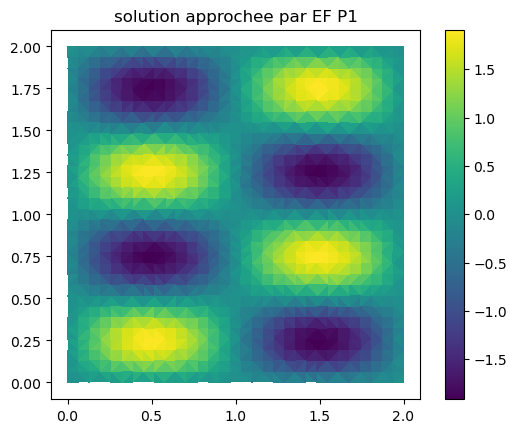

In [8]:
def solution(f):
    V=second_membre(f)    
    
    U = scipy.linalg.solve(KK,V) #ne marche pas car la matrice ne s'inverse pas
    plt.figure(2)
    plt.gca().set_aspect('equal')
    plt.tripcolor(triang.x,triang.y,triang.triangles, U, shading='flat')
    plt.colorbar()
    plt.title('solution approchee par EF P1')
    plt.show()
solution(lambda x,y: (5*np.pi**2)*np.sin(np.pi*x)*np.sin(2*np.pi*y))


Text(0.5, 1.0, 'Sol. exacte pour f(x,y) = 5*pi^2*sin(2pi*y)*sin(pi*x)')

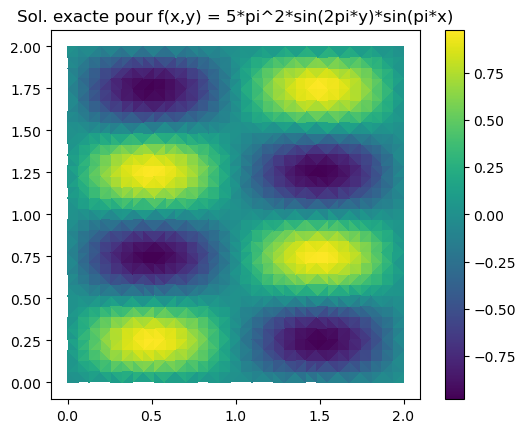

In [9]:
Sol = np.zeros(NSom)
for i in range(NSom):
    x=TabSom[i][0]
    y=TabSom[i][1]
    Sol[i] = np.sin(2*np.pi*y)*np.sin(np.pi*x)
    
plt.gca().set_aspect('equal')
plt.tripcolor(triang.x,triang.y,triang.triangles, Sol, shading='flat')
plt.colorbar()
plt.title('Sol. exacte pour f(x,y) = 5*pi^2*sin(2pi*y)*sin(pi*x)' ) 

#c'est étrange, je n'ai pas l'impression que u=0 sur le bord? 

** D'autres structures de maillage **. On peut utiliser les codes suivants pour créer i) un maillage non cartésien ; ii) un maillage en forme de couronne.

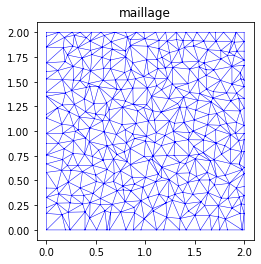

In [13]:
Nx=18
Ny=18

x_m=0.
x_M=2.
y_m=0.
y_M=2.

Rx=rd.random([Nx+2,Nx+2])
Rx[:,0]=0
Rx[:,-1]=0
Ry=rd.random([Ny+2,Ny+2])
Ry[0,:]=0
Ry[-1,:]=0
x=np.linspace(x_m,x_M,Nx+2)#+4*((x_M-x_m)/(5*(Nx+2)))*Rx
y=np.linspace(y_m,y_M,Ny+2)#+4*((y_M-y_m)/(5*(Ny+2)))*Ry

X,Y=np.meshgrid(x,y)
X=X+0.9*((x_M-x_m)/((Nx+2)))*Rx
Y=Y+0.9*((y_M-y_m)/((Ny+2)))*Ry

X=X.flatten()
Y=Y.flatten()

triang = tri.Triangulation(X, Y)

NTri=np.shape(triang.triangles)[0]
NSom=np.shape(triang.x)[0]

#Tableau avec coordonnes des noeuds
TabSom=np.zeros([NSom,2])
TabSom[:,0]=triang.x
TabSom[:,1]=triang.y

# Tableau avec noeuds des triangles
TabTri=triang.triangles

plt.figure(1)
plt.gca().set_aspect('equal')
plt.triplot(X,Y,triang.triangles, 'b-', lw=0.5)
plt.title('maillage')

plt.show()


**Domaine couronne.** 

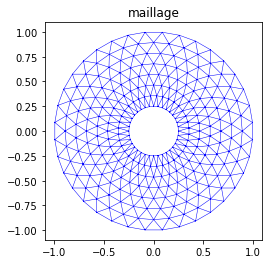

In [29]:
def triangulation_couronne(nrad=8,nang=36):
    radii = np.linspace(0.25, 1, nrad)
    angles = np.linspace(0, 2*np.pi, nang, endpoint=False)
    angles = np.repeat(angles[..., np.newaxis], nrad, axis=1)
    angles[:, 1::2] += np.pi/nang
    x = (radii*np.cos(angles)).flatten()
    y = (radii*np.sin(angles)).flatten()

    # On construit une triangulation de Delaunay et on filtre les triangles proches de l'origine
    triang = tri.Triangulation(x, y)
    xmid = x[triang.triangles].mean(axis=1)
    ymid = y[triang.triangles].mean(axis=1)
    mask = xmid*xmid + ymid*ymid >= .25*.25
    T = triang.triangles[mask,:]
    return x,y,T

[x,y,T] = triangulation_couronne(8,36)


NTri=np.shape(T)[0]
NSom=np.shape(x)[0]

TabSom=np.zeros([NSom,2])
TabSom[:,0]=x
TabSom[:,1]=y

# noeuds des triangles
TabTri=T

plt.figure(1)
plt.gca().set_aspect('equal')
plt.triplot(x,y,T, 'b-', lw=0.5)
plt.title('maillage')

plt.show()


# .... Le programme

